# Import needed libraries and define voronoi child class with labels

In [1]:
import numpy as np 
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt

def voronoi_plot_2d(vor, ax=None, **kw):
    """
    Plot the given Voronoi diagram in 2-D
    Parameters
    ----------
    vor : scipy.spatial.Voronoi instance
        Diagram to plot
    ax : matplotlib.axes.Axes instance, optional
        Axes to plot on
    show_points : bool, optional
        Add the Voronoi points to the plot.
    show_vertices : bool, optional
        Add the Voronoi vertices to the plot.
    line_colors : string, optional
        Specifies the line color for polygon boundaries
    line_width : float, optional
        Specifies the line width for polygon boundaries
    line_alpha : float, optional
        Specifies the line alpha for polygon boundaries
    point_size : float, optional
        Specifies the size of points
    Returns
    -------
    fig : matplotlib.figure.Figure instance
        Figure for the plot
    """
    from matplotlib.collections import LineCollection

    if vor.points.shape[1] != 2:
        raise ValueError("Voronoi diagram is not 2-D")

    if kw.get('show_points', True):
        point_size = kw.get('point_size', None)
        ax.scatter(vor.points[:,0], vor.points[:,1], marker ='.', cmap = 'brg', c = vor.labels, s= point_size)
    if kw.get('show_vertices', True):
        ax.plot(vor.vertices[:,0], vor.vertices[:,1], 'o')

    line_colors_relevant = kw.get('line_colors_relevant','k')
    line_colors_irrelevant = kw.get('line_colors_irrelevant', 'k')
    line_width_relevant = kw.get('line_width_relevant',2.0)
    line_width_irrelevant = kw.get('line_width_irrelevant',1.0)
    line_alpha_relevant = kw.get('line_alpha_relevant',1.0)
    line_alpha_irrelevant = kw.get('line_alpha_irrelevant',0.5)
    line_style_relevant = kw.get('line_style_relevant','solid')
    line_style_irrelevant = kw.get('line_style_irrelevant','dotted') 

    center = vor.points.mean(axis=0)
    ptp_bound = vor.points.ptp(axis=0)
    
    finite_segments = []
    finite_relevant_segments = []
    infinite_segments = []
    infinite_relevant_segments = []
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        
        if np.all(simplex >= 0):
            if (vor.labels[pointidx[0]] != vor.labels[pointidx[1]]):
                finite_relevant_segments.append(vor.vertices[simplex])
            else:
                finite_segments.append(vor.vertices[simplex])
        else:
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            if (vor.furthest_site):
                direction = -direction
            far_point = vor.vertices[i] + direction * ptp_bound.max()
            if (vor.labels[pointidx[0]] != vor.labels[pointidx[1]]):
                infinite_relevant_segments.append([vor.vertices[i], far_point])
            else: 
                infinite_segments.append([vor.vertices[i], far_point])

                
    show_irrelevant = kw.get('show_irrelevant', True)
    
    
    ax.add_collection(LineCollection(finite_relevant_segments,
                                     colors=line_colors_relevant,
                                     lw=line_width_relevant,
                                     alpha=line_alpha_relevant,
                                     linestyle=line_style_relevant))
    
    ax.add_collection(LineCollection(infinite_relevant_segments,
                                     colors=line_colors_relevant,
                                     lw=line_width_relevant,
                                     alpha=line_alpha_relevant,
                                     linestyle=line_style_relevant))


    
    if show_irrelevant == True: 
        ax.add_collection(LineCollection(finite_segments,
                                         colors=line_colors_irrelevant,
                                         lw=line_width_irrelevant,
                                         alpha=line_alpha_irrelevant,
                                         linestyle=line_style_irrelevant))


        ax.add_collection(LineCollection(infinite_segments,
                                         colors=line_colors_irrelevant,
                                         lw=line_width_irrelevant,
                                         alpha=line_alpha_irrelevant,
                                         linestyle=line_style_irrelevant))
    
    
    _adjust_bounds(ax, vor.points)

    return ax.figure
def _adjust_bounds(ax, points):
    margin = 0.1 * points.ptp(axis=0)
    xy_min = points.min(axis=0) - margin
    xy_max = points.max(axis=0) + margin
    ax.set_xlim(xy_min[0], xy_max[0])
    ax.set_ylim(xy_min[1], xy_max[1])
    
    
# define a child class of the voronoi diagram that also includes the lables 

class Voronoi_with_color(Voronoi):
    def __init__(self, data):
        data = np.asarray(data)
        points_without_labels = data[:, 0:-1]
        # print(points_without_labels)
        labels = data[:,-1] 
        Voronoi.__init__(self,points_without_labels)
        self.labels = labels
        self.points_with_labels = data

# First implementation of border point algorithm

In [2]:
from scipy.spatial import ConvexHull

# returns the index of the vertices of the convex hull of datapoints 
def find_extremepoint_of_conv_hull(dataset): 
    dataset = np.array(dataset)
    convhull = ConvexHull(dataset)
    return convhull.vertices

# returns tuple of the points reverted around a unitsphere
def invert_around_sphere(dataset, center_point): 
    dataset = np.array(dataset)
    inverted_dataset = []
    for point in dataset:
        distance = np.linalg.norm(point - center_point)
        if distance != 0: 
            inverted_point = center_point + (point - center_point)/distance**2 
        else: 
            inverted_point = point
        inverted_dataset.append(inverted_point)
    return np.array(inverted_dataset)

# @njit
def calculate_border_points(dataset): 
    seed_point = dataset[0].tolist()
    relevant_points = [seed_point]
    for index, point in enumerate(relevant_points): 
        current_label = point[-1]
        #filter for the points that have a different label
        filter_data = (dataset[:,-1] != current_label)
        current_dataset = dataset[filter_data]
        current_dataset = np.append(current_dataset, [point], axis=0)
        #invet points and remove the label from the dataset (last entry)
        inverted_points = invert_around_sphere(current_dataset[:, 0:-1], point[0:-1])
        extreme_point_index = find_extremepoint_of_conv_hull(inverted_points)
        new_relevant_points = current_dataset[extreme_point_index].tolist() 

        for i in new_relevant_points: 
            if i in relevant_points: 
                relevant_points
            else:
                relevant_points.append(i)
    #remove the seedpoint which is at the 0-th position 
    del relevant_points[0]
        # print('relevant_points ', relevant_points, '\n')
    return relevant_points
# plot the points (only first two dimensions and up to 5 different labels)

def plot_points(dataset):  
    dataset = np.array(dataset)
    plt.scatter(dataset[:,0],dataset[:,1], marker = '.', cmap = 'brg',c = dataset[:,-1])
    plt.show()
    
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

# Relevant points that is not a min cardinality subset 

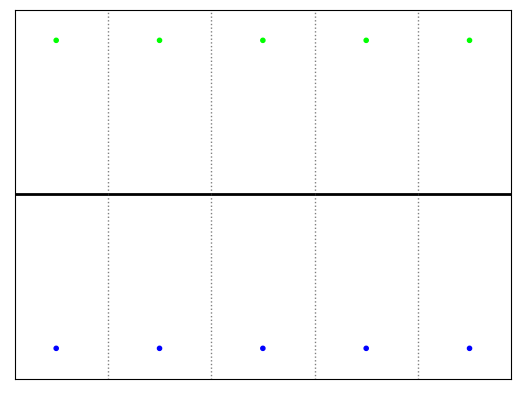

In [3]:
dataset = np.array([[1,1,0], [2,1,0], [3,1,0], [4,1,0], [5,1,0], [1,2,1], [2,2,1], [3,2,1], [4,2,1], [5,2,1]])
dataset2 = np.array([[1,1,0], [2,1,0], [4,1,0], [5,1,0], [1,2,1], [2,2,1], [3,2,1], [4,2,1], [5,2,1]])

vor = Voronoi_with_color(dataset)
vor2 = Voronoi_with_color(dataset2)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax = ax, show_vertices = False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# plt.savefig('../Figures/points_in_a_line')


# No min cardinality subset in set of relevant points 

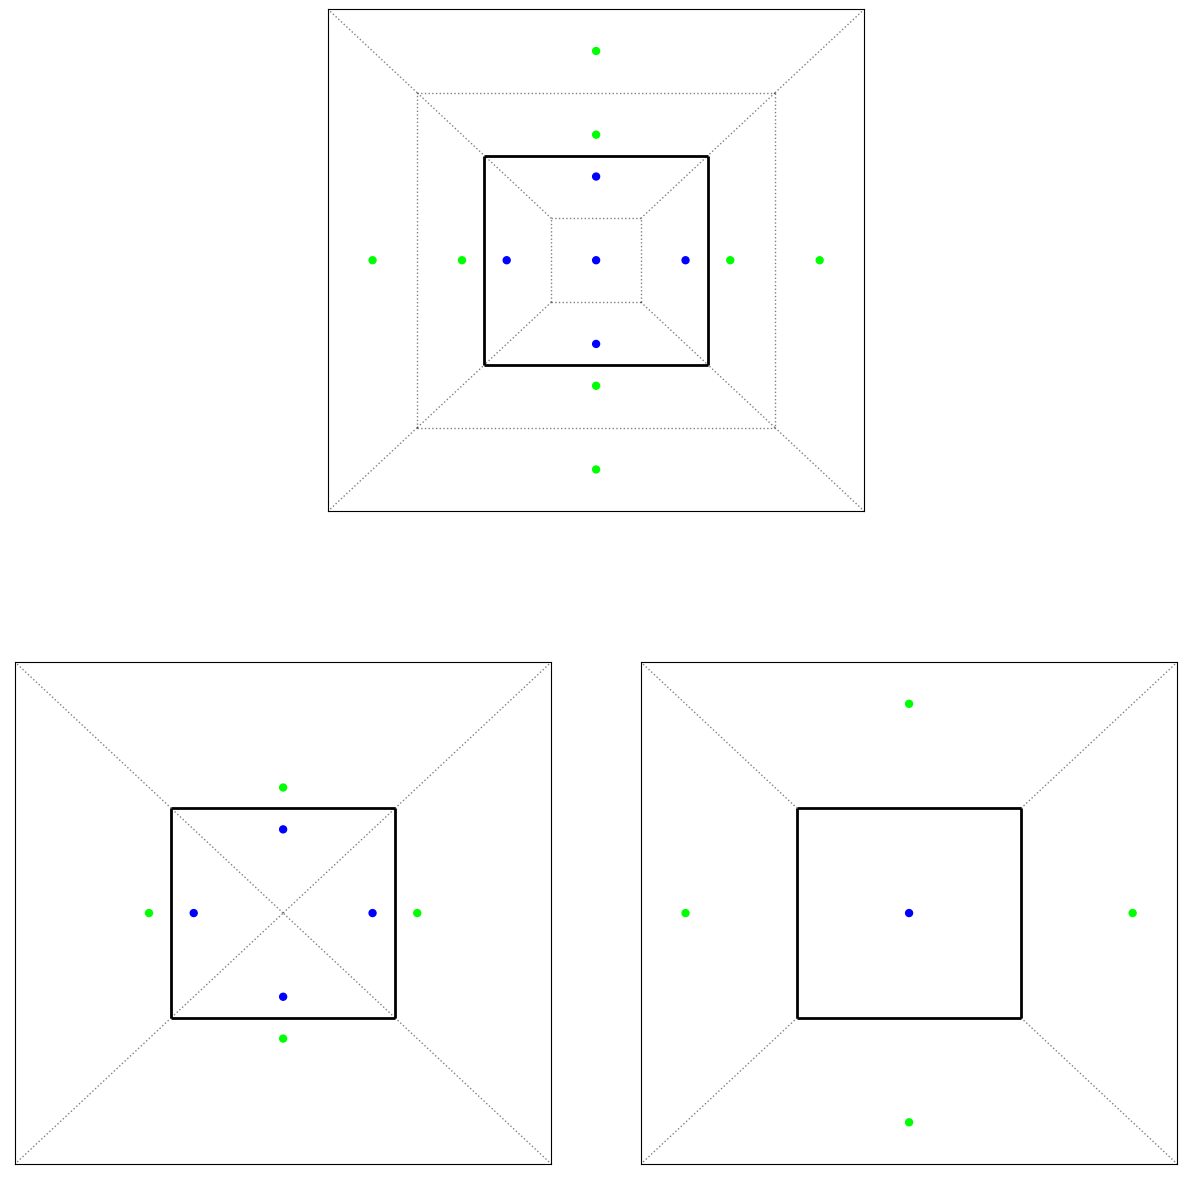

<Figure size 2500x500 with 0 Axes>

In [4]:
dataset = np.array([[0,0,0], [0,5,1], [0,2,0], [0,3,1], [5,0,1], [2,0,0], [3,0,1], [0,-5,1], [0,-2,0], [0,-3,1], [-5,0,1], [-2,0,0], [-3,0,1]])
vor = Voronoi_with_color(dataset)
fig = plt.figure(figsize = (15,15))
grid = plt.GridSpec(2, 4,figure=fig, wspace=0.4, hspace=0.3 )
ax1 = plt.subplot(grid[0,1:3])
ax2 = plt.subplot(grid[1,:2])
ax3  = plt.subplot(grid[1,2:4])
plt.figure(figsize = (25,5))
# fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize = (15,5))
voronoi_plot_2d(vor, ax = ax1, show_vertices = False, show_irrelevant = True, point_size= 100 )
filtered_dataset = calculate_border_points(dataset)
vor2 = Voronoi_with_color(filtered_dataset)
voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True, point_size= 100 )
ax2.set_xlim([-6, 6])
ax2.set_ylim([-6, 6])
vor3 = Voronoi_with_color( np.array([[0,0,0], [0,5,1], [5,0,1], [0,-5,1], [-5,0,1]]))
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True,  point_size= 100  )
ax3.set_xlim([-6, 6])
ax3.set_ylim([-6, 6])

# remove axis labels 
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
# fig.savefig('../Figures/local_minima')
plt.show()

## The original clause gadget

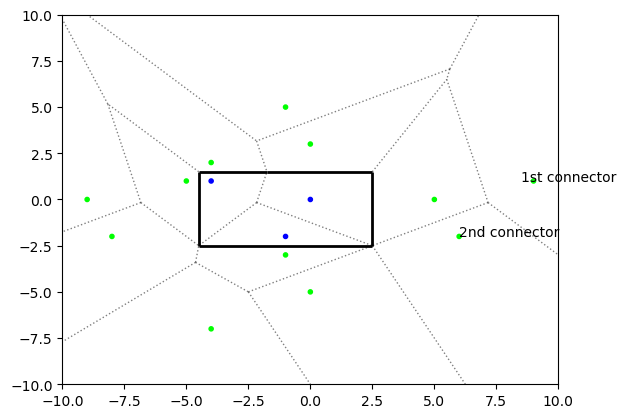

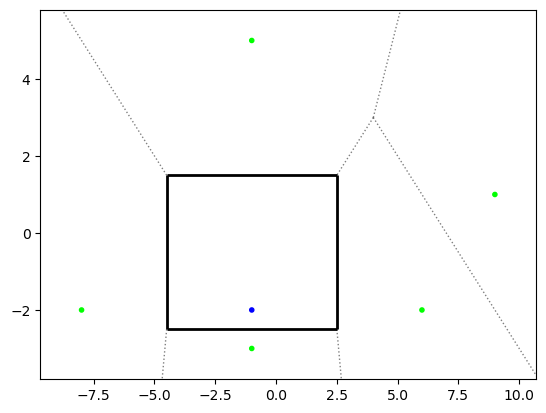

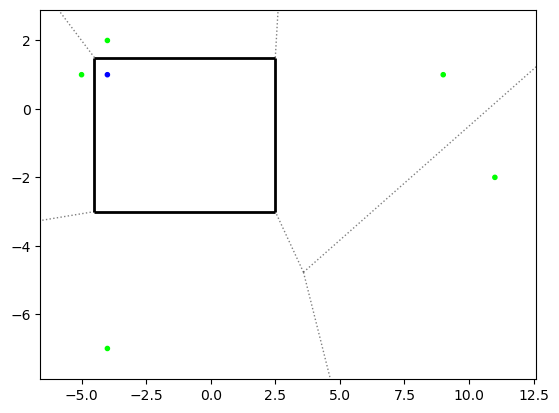

In [5]:
first_possible_subset = np.array([[0,0,0], [0,3,1], [5,0,1],  [0,-5,1],[-9,0,1]])
second_possible_subset = np.array([[-4,1,0], [-4,2,1], [-5,1,1],[9,1,1], [-4,-7,1]])
third_possible_subset = np.array([[-1,-2,0], [-1,-3,1], [-8,-2,1],[6,-2,1], [-1,5,1]])
fourth_possible_subset = np.array([[0,0,0], [0,5,1],  [0,-5,1],[-5,0,1]])
dataset = np.concatenate((first_possible_subset, second_possible_subset, third_possible_subset))
# dataset = np.array([[0,0,0], [0,5,1], [5,0,1],  [0,-5,1],[-5,0,1], [-2,2,0], [-2,3,1], [-3,2,1],[7,2,1], [-2,-7,1]])

vor = Voronoi_with_color(dataset)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax = ax, show_vertices = False, show_irrelevant = True )
ax.annotate('1st connector', [8.5,1])
ax.annotate('2nd connector', [6,-2])
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget')
plt.show()


vor2 = Voronoi_with_color(np.concatenate((third_possible_subset, [[9,1,1]])))
fig, ax2 = plt.subplots()
voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True )
# ax2.set_xlim([-10, 10])
# ax2.set_ylim([-10, 10])
# ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget_both')
plt.show()

vor3 = Voronoi_with_color(np.concatenate((second_possible_subset, [[11,-2,1]])))
fig, ax3 = plt.subplots()
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True )
ax2.set_xlim([-10, 10])
ax2.set_ylim([-10, 10])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget_both')
plt.show()

# vor3 = Voronoi_with_color(second_possible_subset)
# vor4 = Voronoi_with_color(third_possible_subset)
# fig, ax3 = plt.subplots(2,1)
# voronoi_plot_2d(vor4, ax = ax4, show_vertices = False, show_irrelevant = True )
# voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True )

# ax4.set_xlim([-10, 10])
# ax4.set_ylim([-10, 10])
# ax4.get_xaxis().set_visible(False)
# ax4.get_yaxis().set_visible(False)
# ax3.set_xlim([-10, 10])
# ax3.set_ylim([-10, 10])
# ax3.get_xaxis().set_visible(False)
# ax3.get_yaxis().set_visible(False)
# # fig.savefig('../Figures/clause_gadget_one')
# plt.show()

# The problem with the clause gadget

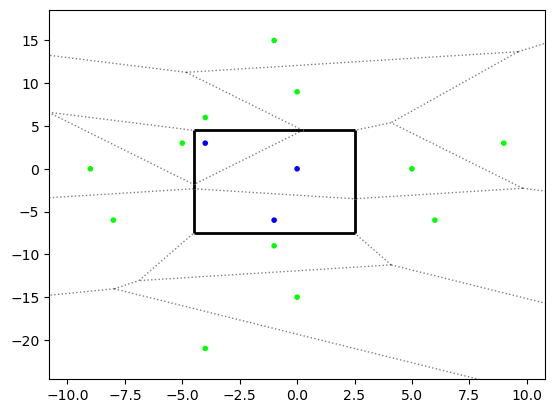

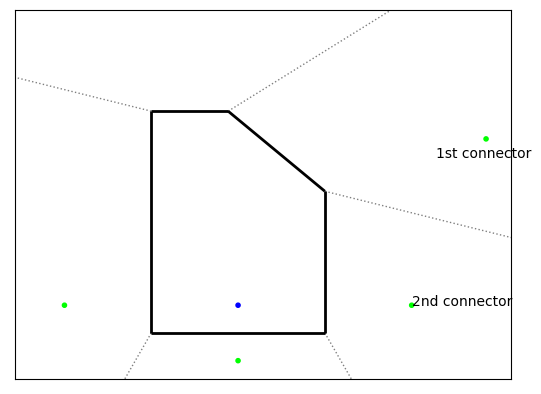

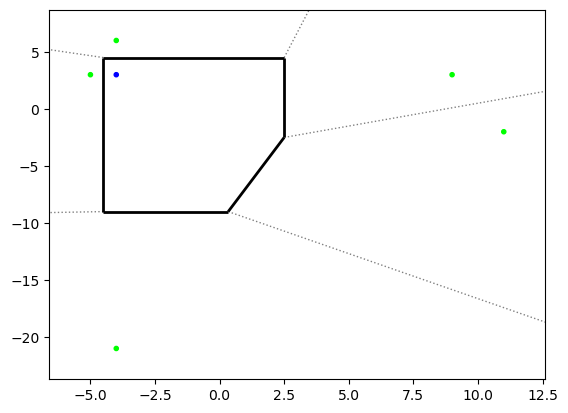

In [6]:
first_possible_subset = np.array([[0,0,0], [0,9,1], [5,0,1],  [0,-15,1],[-9,0,1]])
second_possible_subset = np.array([[-4,3,0], [-4,6,1], [-5,3,1],[9,3,1], [-4,-21,1]])
third_possible_subset = np.array([[-1,-6,0], [-1,-9,1], [-8,-6,1],[6,-6,1], [-1,15,1]])
dataset = np.concatenate((first_possible_subset, second_possible_subset, third_possible_subset))

vor = Voronoi_with_color(dataset)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax = ax, show_vertices = False, show_irrelevant = True )
# ax.annotate('1st connector', [8.5,1])
# ax.annotate('2nd connector', [6,-2])
# ax.set_xlim([-10, 15])
# ax.set_ylim([-10, 15])
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget')
plt.show()


vor2 = Voronoi_with_color(np.concatenate((third_possible_subset, [second_possible_subset[3]])))
fig, ax2 = plt.subplots()
voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True )
ax2.set_xlim([-10, 10])
ax2.set_ylim([-10, 10])
ax2.annotate('2nd connector', [6,-6])
ax2.annotate('1st connector', [7,2])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget_messedup')
plt.show()

vor3 = Voronoi_with_color(np.concatenate((second_possible_subset, [[11,-2,1]])))
fig, ax3 = plt.subplots()
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True )
# ax3.set_xlim([-10, 10])
# ax3.set_ylim([-10, 10])
# ax3.get_xaxis().set_visible(False)
# ax3.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget_both')
plt.show()

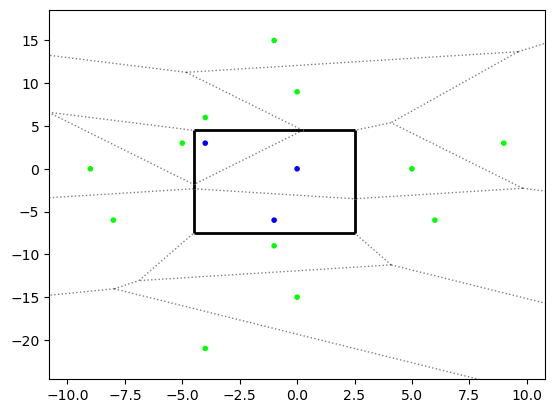

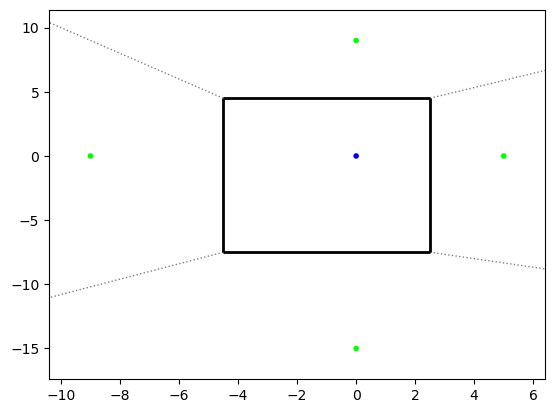

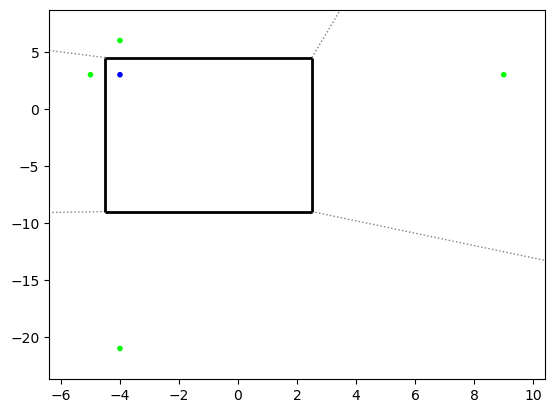

In [7]:
first_possible_subset = np.array([[0,0,0], [0,9,1], [5,0,1],  [0,-15,1],[-9,0,1]])
second_possible_subset = np.array([[-4,3,0], [-4,6,1], [-5,3,1],[9,3,1], [-4,-21,1]])
third_possible_subset = np.array([[-1,-6,0], [-1,-9,1], [-8,-6,1],[6,-6,1], [-1,15,1]])
dataset = np.concatenate((first_possible_subset, second_possible_subset, third_possible_subset))

vor = Voronoi_with_color(dataset)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax = ax, show_vertices = False, show_irrelevant = True )
plt.show()


vor2 = Voronoi_with_color(first_possible_subset)
fig, ax2 = plt.subplots()
voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True )
plt.show()

vor3 = Voronoi_with_color(second_possible_subset)
fig, ax3 = plt.subplots()
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True )
plt.show()

# Solutions to that problem

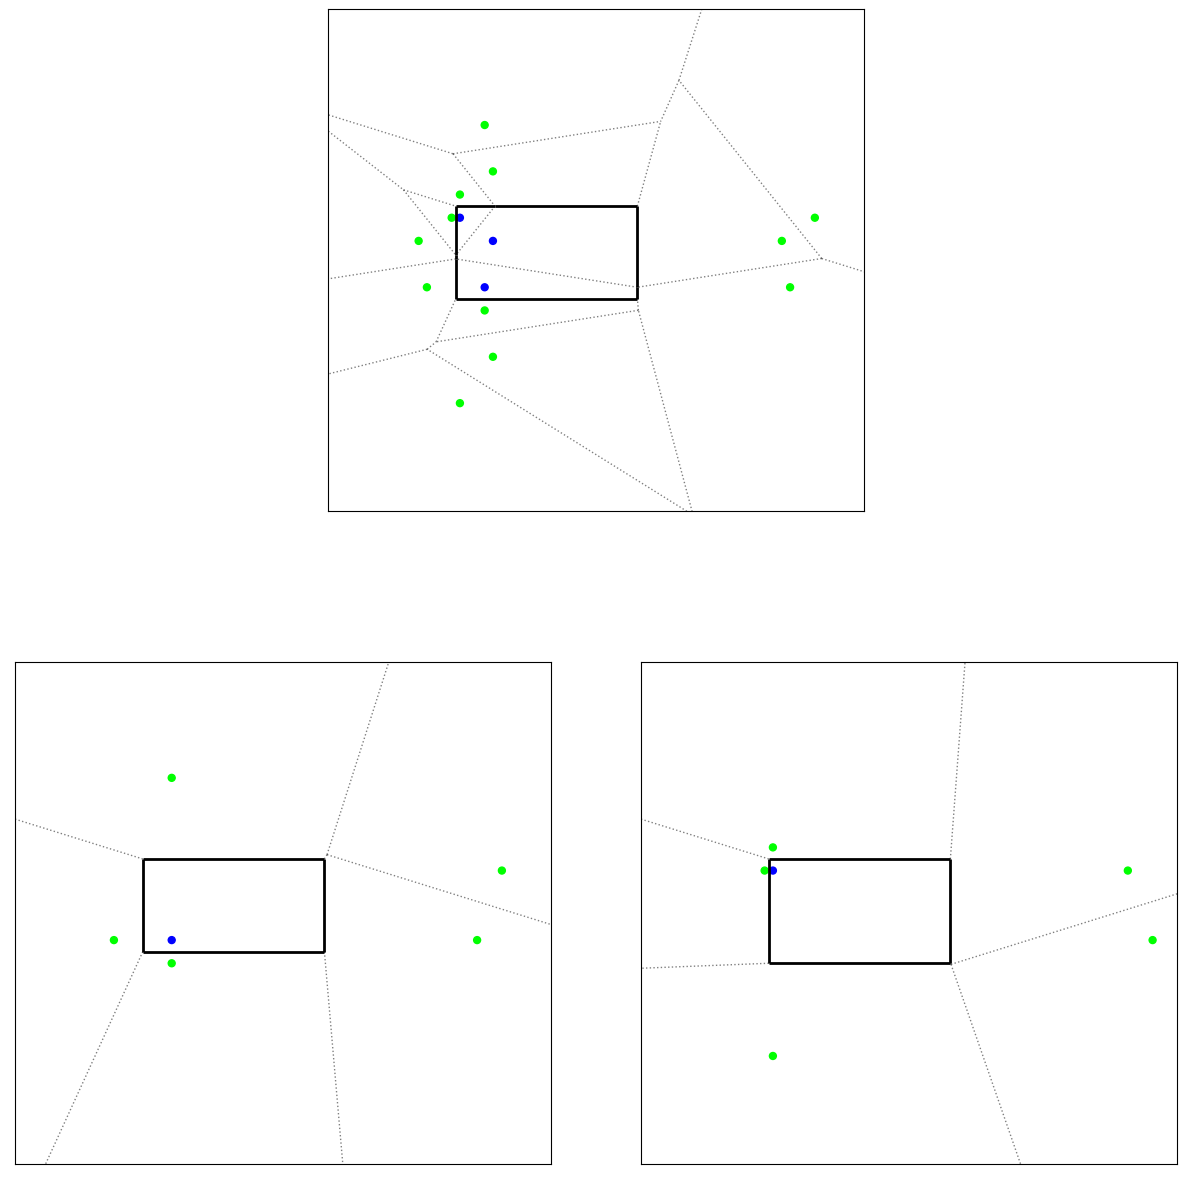

<Figure size 2500x500 with 0 Axes>

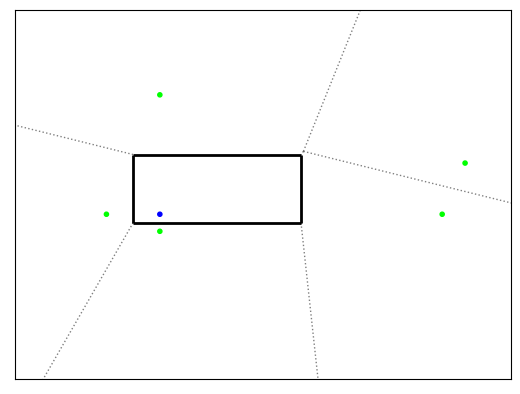

In [8]:
first_possible_subset = np.array([[-30,0,0], [-30,9,1], [-30,-15,1], [-39,0,1], [5,0,1],])
second_possible_subset = np.array([[-34,3,0], [-34,6,1], [-35,3,1], [-34,-21,1],[9,3,1]])
third_possible_subset = np.array([[-31,-6,0], [-31,-9,1], [-38,-6,1], [-31,15,1],[6,-6,1]])
dataset = np.concatenate((first_possible_subset, second_possible_subset, third_possible_subset))

fig = plt.figure(figsize = (15,15))
grid = plt.GridSpec(2, 4,figure=fig, wspace=0.4, hspace=0.3 )
ax = plt.subplot(grid[0,1:3])
ax2 = plt.subplot(grid[1,:2])
ax3  = plt.subplot(grid[1,2:4])
plt.figure(figsize = (25,5))

vor = Voronoi_with_color(dataset)
voronoi_plot_2d(vor, ax = ax, show_vertices = False, show_irrelevant = True, point_size= 100  )
# ax.annotate('1st connector', [8.5,1])
# ax.annotate('2nd connector', [6,-2])
ax.set_xlim([-50, 15])
ax.set_ylim([-35, 30])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget_shifted')


# fig, [ax2,ax3] = plt.subplots(1,2, figsize = (10,5))
vor2 = Voronoi_with_color(np.concatenate((third_possible_subset, [second_possible_subset[4]])))

voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True , point_size= 100 )
ax2.set_xlim([-50, 15])
ax2.set_ylim([-35, 30])
# ax2.annotate('1st connector', [6,-6])
# ax2.annotate('2nd connector', [7,1])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget_messedup')


vor3 = Voronoi_with_color(np.concatenate((second_possible_subset, [[12,-6,1]])))
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True, point_size= 100  )
ax3.set_xlim([-50, 15])
ax3.set_ylim([-35, 30])
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget_both')
plt.show()
fig, ax4 = plt.subplots()
voronoi_plot_2d(vor2, ax = ax4, show_vertices = False, show_irrelevant = True )
ax4.set_xlim([-50, 15])
ax4.set_ylim([-35, 30])
# ax2.annotate('1st connector', [6,-6])
# ax2.annotate('2nd connector', [7,1])
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
# fig.savefig('../Figures/clause_gadget_shifted_bounded_distance')
plt.show()

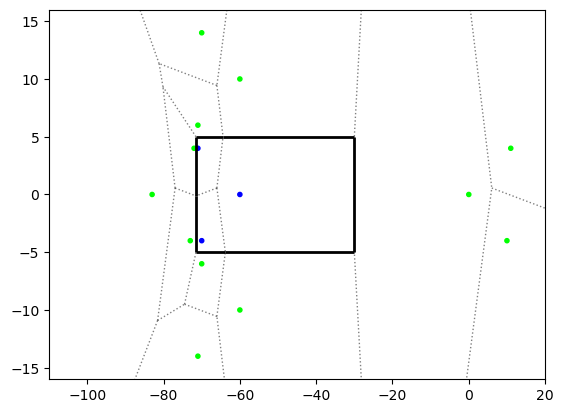

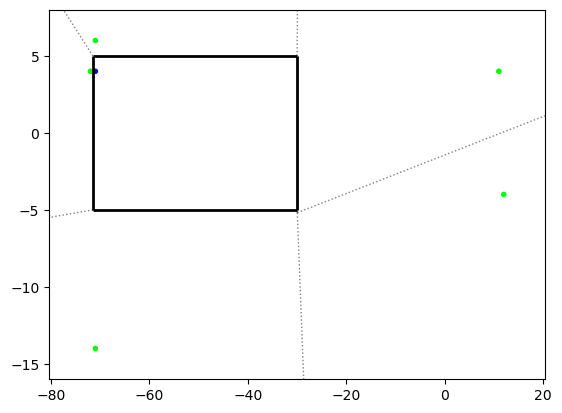

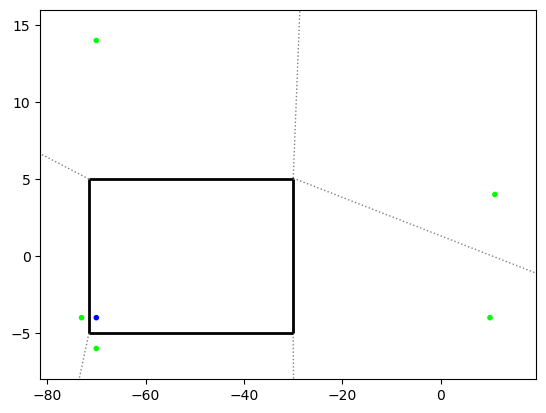

In [9]:
first_possible_subset = np.array([[-60,0,0],[0,0,1],[-60,10,1],[-60,-10,1],[-83,0,1]])
second_possible_subset = np.array([[11,4,1],[-71,4,0],[-71,6,1], [-71,-14,1],[-72,4,1]])
third_possible_subset = np.array([[10,-4,1],[-70,-4,0],[-70,-6,1],[-70,14,1],[-73,-4,1]])

dataset = np.concatenate((first_possible_subset,second_possible_subset, third_possible_subset))
# dataset = np.array([[0,0,0], [0,5,1], [5,0,1],  [0,-5,1],[-5,0,1], [-2,2,0], [-2,3,1], [-3,2,1],[7,2,1], [-2,-7,1]])

vor = Voronoi_with_color(dataset)
# print(dataset)
# print(vor.vertices)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax = ax, show_vertices = False, show_irrelevant = True )
ax.set_xlim([-110, 20])
ax.set_ylim([-16, 16])
plt.show()


vor2 = Voronoi_with_color(np.concatenate((second_possible_subset, [[12,-4,1]])))
fig, ax2 = plt.subplots()
voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True )
plt.show()
# print(vor2.vertices)
vor3 = Voronoi_with_color(np.concatenate((third_possible_subset, [[11,4,1]])))
fig, ax3 = plt.subplots()
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True )
# ax2.set_xlim([-10, 10])
# ax2.set_ylim([-10, 10])
# ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
# print(vor3.vertices)
# fig.savefig('../Figures/clause_gadget_both')
plt.show()


# Connector gadget (sorry for the incredibly ugly code :'), I flipped the plot last second)

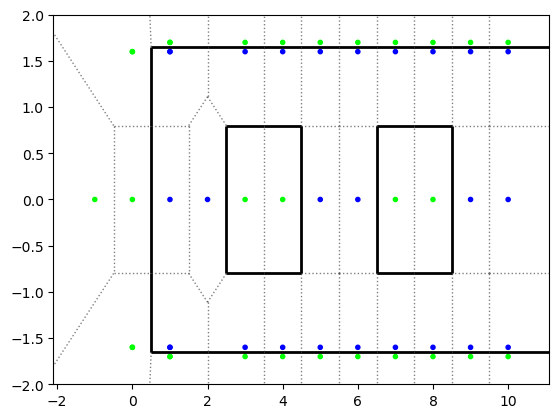

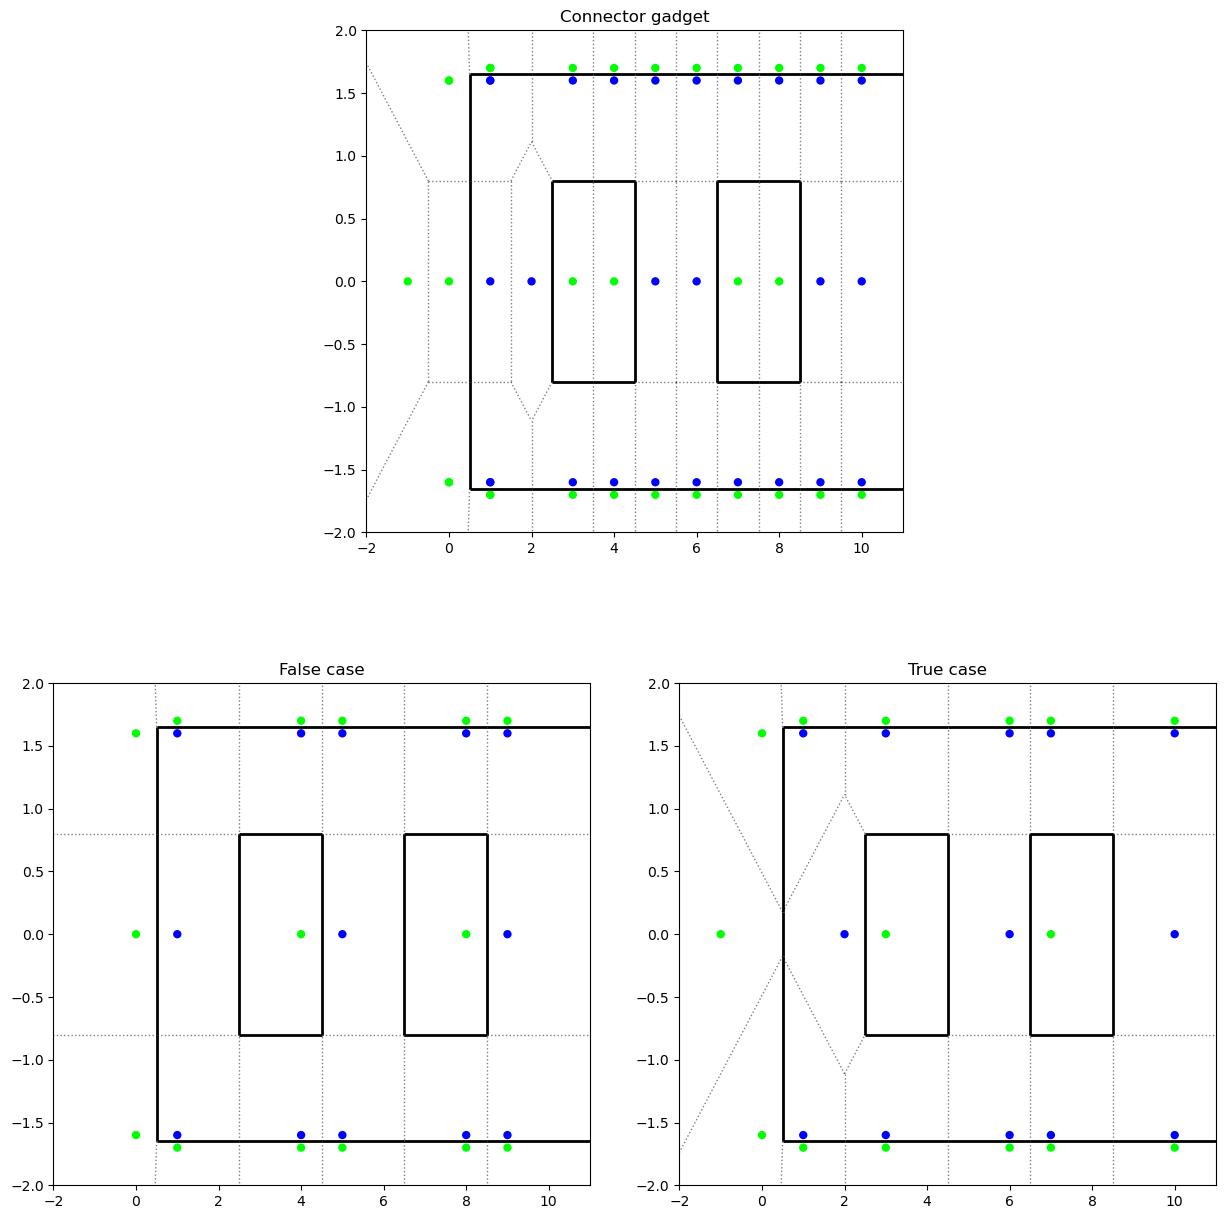

In [10]:
# dataset = np.array([[-7,0,1],[-6,0,0],[-4,1,0], [-4,2,1],[-5,1,0], [-5,2,1],[-3,0,0],[-2,0,1], [1,0,1], [2,0,0], [5,0,0], [6,0,1], [5,2.5,0]])
true_connector = np.array([[-10,0,0],[-7,0,1], [-6,0,0], [-3,0,1], [-2,0,0],[1,0,1]])
true_shielding = np.array([ [-10,1.6,0], [-10,1.7,1], [-10,-1.6,0], [-10,-1.7,1],[-7,1.6,0], [-7,1.7,1], [-7,-1.6,0], [-7,-1.7,1],[-6,1.6,0], [-6,1.7,1], [-6,-1.6,0], [-6,-1.7,1],[-3,1.6,0], [-3,1.7,1], [-3,-1.6,0], [-3,-1.7,1],[-1,1.6,0], [-1,1.7,1], [-1,-1.6,0], [-1,-1.7,1], [0,1.6,1],[0,-1.6,1]])
false_connector = np.array([[-9,0,0],[-8,0,1] , [-5,0,0], [-4,0,1], [-1,0,0],[0,0,1]])
false_shielding = np.array([[-9,1.6,0], [-9,1.7,1], [-9,-1.6,0], [-9,-1.7,1],[-8,1.6,0], [-8,1.7,1], [-8,-1.6,0], [-8,-1.7,1],[-5,1.6,0], [-5,1.7,1], [-5,-1.6,0], [-5,-1.7,1],[-4,1.6,0], [-4,1.7,1], [-4,-1.6,0], [-4,-1.7,1], [-1,1.6,0], [-1,1.7,1], [-1,-1.6,0], [-1,-1.7,1], [0,1.6,1], [0,-1.6,1]])

#flip plot
templist = true_connector.tolist()
for i in templist: 
    i[0] = -i[0]
true_connector = np.array(templist)

templist = true_shielding.tolist()
for i in templist: 
    i[0] = -i[0]
true_shielding = np.array(templist)

templist = false_connector.tolist()
for i in templist: 
    i[0] = -i[0]
false_connector = np.array(templist)

templist = false_shielding.tolist()
for i in templist: 
    i[0] = -i[0]
false_shielding = np.array(templist)


dataset = np.concatenate((true_connector,false_connector, true_shielding,false_shielding))
vor1 = Voronoi_with_color(np.concatenate((true_connector,false_connector, true_shielding,false_shielding)))
vor2 = Voronoi_with_color(np.concatenate((false_connector, false_shielding)))
vor3 = Voronoi_with_color(np.concatenate((true_connector, true_shielding)))



fig, ax = plt.subplots()
voronoi_plot_2d(vor1, ax = ax, show_vertices = False, show_irrelevant = True )
ax.set_ylim([-2,2])

fig = plt.figure(figsize = (15,15))
grid = plt.GridSpec(2, 4,figure=fig, wspace=0.4, hspace=0.3 )
ax1 = plt.subplot(grid[0,1:3])
ax2 = plt.subplot(grid[1,:2])
ax3  = plt.subplot(grid[1,2:4])
voronoi_plot_2d(vor1, ax = ax1, show_vertices = False, show_irrelevant = True, point_size= 100 )
voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True, point_size= 100 )
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True, point_size= 100 )
ax1.set_ylim([-2,2])
ax1.set_xlim([-2,11])
# ax1.get_xaxis().set_visible(False)
# ax1.get_yaxis().set_visible(False)
ax1.set_title('Connector gadget')

ax2.set_ylim([-2,2])
ax2.set_xlim([-2,11])
# ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
ax2.set_title('False case')

ax3.set_ylim([-2,2])
ax3.set_xlim([-2,11])
# ax3.get_xaxis().set_visible(False)
# ax3.get_yaxis().set_visible(False)
ax3.set_title('True case')
plt.show()

52 4503599627370496


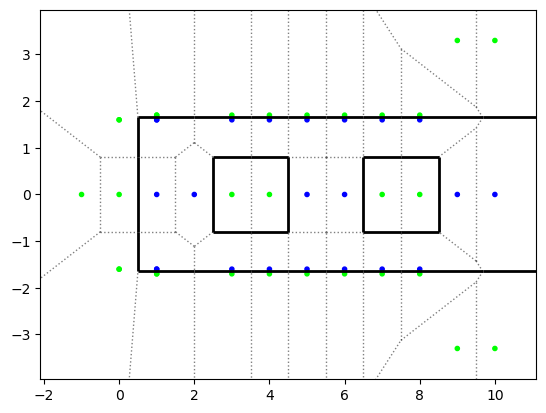

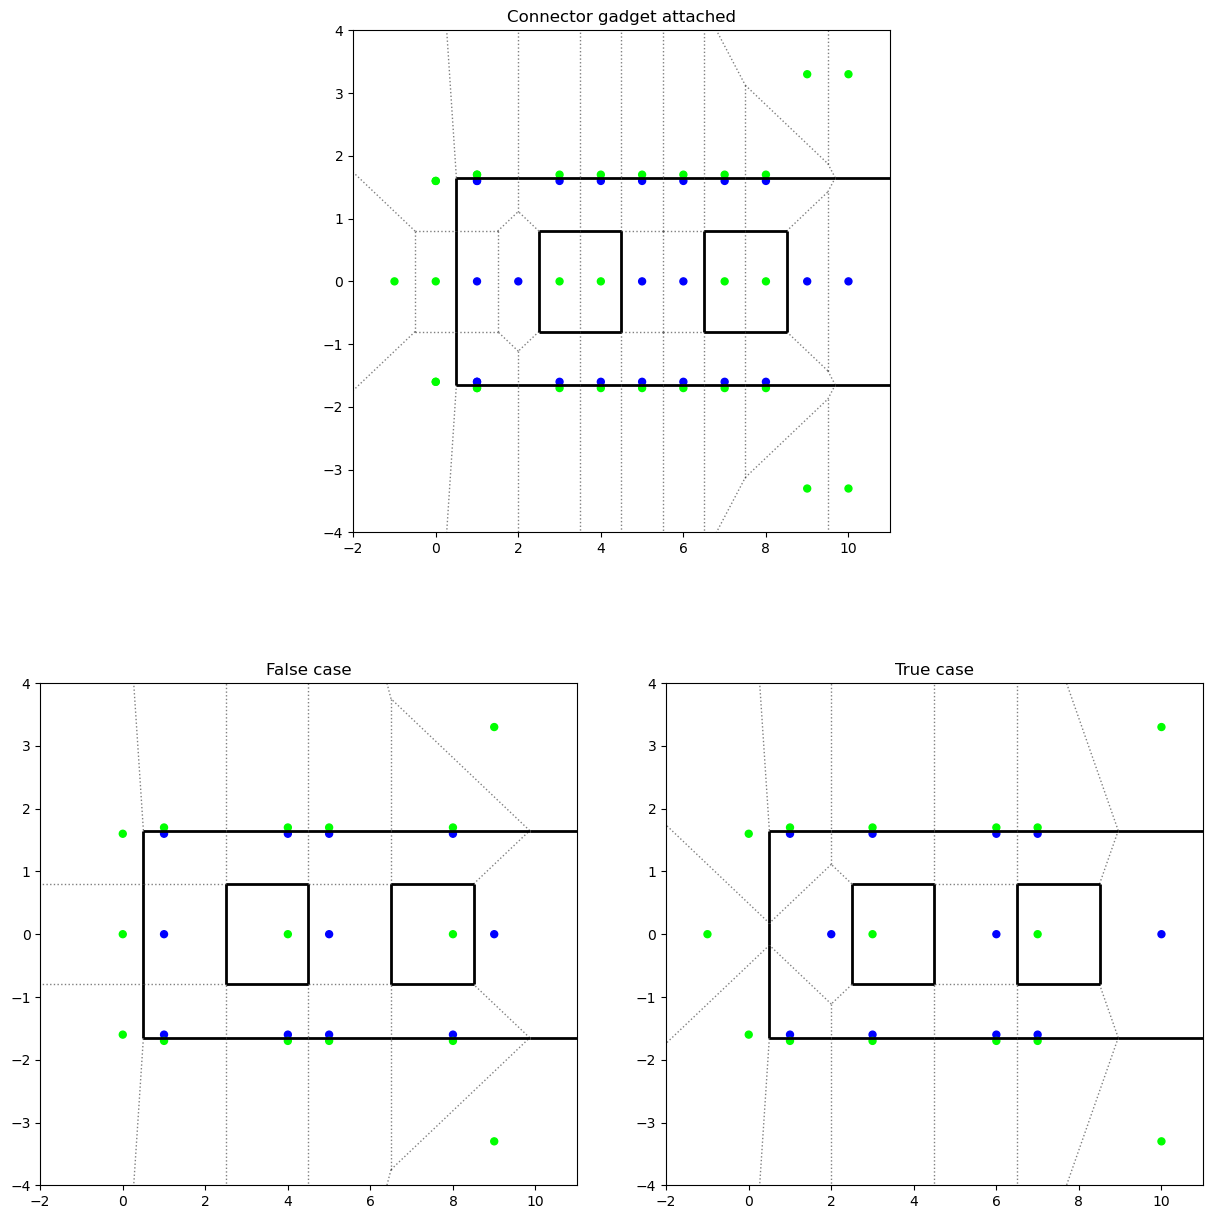

In [11]:
# dataset = np.array([[-7,0,1],[-6,0,0],[-4,1,0], [-4,2,1],[-5,1,0], [-5,2,1],[-3,0,0],[-2,0,1], [1,0,1], [2,0,0], [5,0,0], [6,0,1], [5,2.5,0]])
true_connector = np.array([[-10,0,0],[-7,0,1], [-6,0,0], [-3,0,1], [-2,0,0],[1,0,1]])
true_shielding = np.array([ [-7,1.6,0], [-7,1.7,1], [-7,-1.6,0], [-7,-1.7,1],[-6,1.6,0], [-6,1.7,1], [-6,-1.6,0], [-6,-1.7,1],[-3,1.6,0], [-3,1.7,1], [-3,-1.6,0], [-3,-1.7,1],[-1,1.6,0], [-1,1.7,1], [-1,-1.6,0], [-1,-1.7,1], [0,1.6,1],[0,-1.6,1]])
false_connector = np.array([[-9,0,0],[-8,0,1] , [-5,0,0], [-4,0,1], [-1,0,0],[0,0,1]])
false_shielding = np.array([[-8,1.6,0], [-8,1.7,1], [-8,-1.6,0], [-8,-1.7,1],[-5,1.6,0], [-5,1.7,1], [-5,-1.6,0], [-5,-1.7,1],[-4,1.6,0], [-4,1.7,1], [-4,-1.6,0], [-4,-1.7,1], [-1,1.6,0], [-1,1.7,1], [-1,-1.6,0], [-1,-1.7,1], [0,1.6,1], [0,-1.6,1]])
variable_gadget_true = np.array([[-10,3.3,1], [-10,-3.3,1] ])
variable_gadget_false = np.array([[-9,3.3,1], [-9,-3.3,1] ])

#flip plot
templist = true_connector.tolist()
for i in templist: 
    i[0] = -i[0]
true_connector = np.array(templist)

templist = true_shielding.tolist()
for i in templist: 
    i[0] = -i[0]
true_shielding = np.array(templist)

templist = false_connector.tolist()
for i in templist: 
    i[0] = -i[0]
false_connector = np.array(templist)

templist = false_shielding.tolist()
for i in templist: 
    i[0] = -i[0]
false_shielding = np.array(templist)

templist = variable_gadget_true.tolist()
for i in templist: 
    i[0] = -i[0]
variable_gadget_true = np.array(templist)

templist = variable_gadget_false.tolist()
for i in templist: 
    i[0] = -i[0]
variable_gadget_false = np.array(templist)


dataset = np.concatenate((true_connector,false_connector, true_shielding,false_shielding))
vor1 = Voronoi_with_color(np.concatenate((true_connector,false_connector, true_shielding,false_shielding, variable_gadget_true, variable_gadget_false)))
vor2 = Voronoi_with_color(np.concatenate((false_connector, false_shielding,variable_gadget_false)))
vor3 = Voronoi_with_color(np.concatenate((true_connector, true_shielding,variable_gadget_true)))
print(len(vor1.points), 2**52)


fig, ax = plt.subplots()
voronoi_plot_2d(vor1, ax = ax, show_vertices = False, show_irrelevant = True )
# ax.set_ylim([-2,2])

fig = plt.figure(figsize = (15,15))
grid = plt.GridSpec(2, 4,figure=fig, wspace=0.4, hspace=0.3 )
ax1 = plt.subplot(grid[0,1:3])
ax2 = plt.subplot(grid[1,:2])
ax3  = plt.subplot(grid[1,2:4])
voronoi_plot_2d(vor1, ax = ax1, show_vertices = False, show_irrelevant = True, point_size= 100 )
voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True, point_size= 100 )
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True, point_size= 100 )
ax1.set_ylim([-4,4])
ax1.set_xlim([-2,11])
# ax1.get_xaxis().set_visible(False)
# ax1.get_yaxis().set_visible(False)
ax1.set_title('Connector gadget attached')

ax2.set_ylim([-4,4])
ax2.set_xlim([-2,11])
# ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
ax2.set_title('False case')

ax3.set_ylim([-4,4])
ax3.set_xlim([-2,11])
# ax3.get_xaxis().set_visible(False)
# ax3.get_yaxis().set_visible(False)
ax3.set_title('True case')
plt.show()

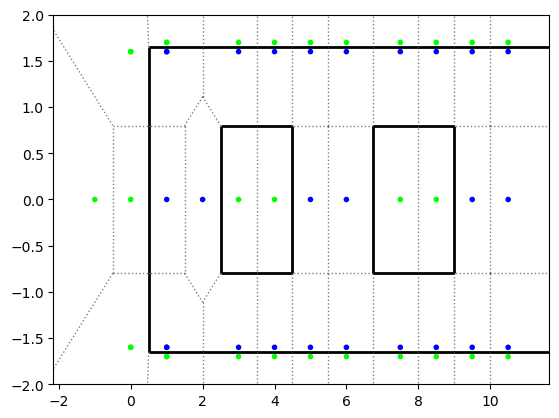

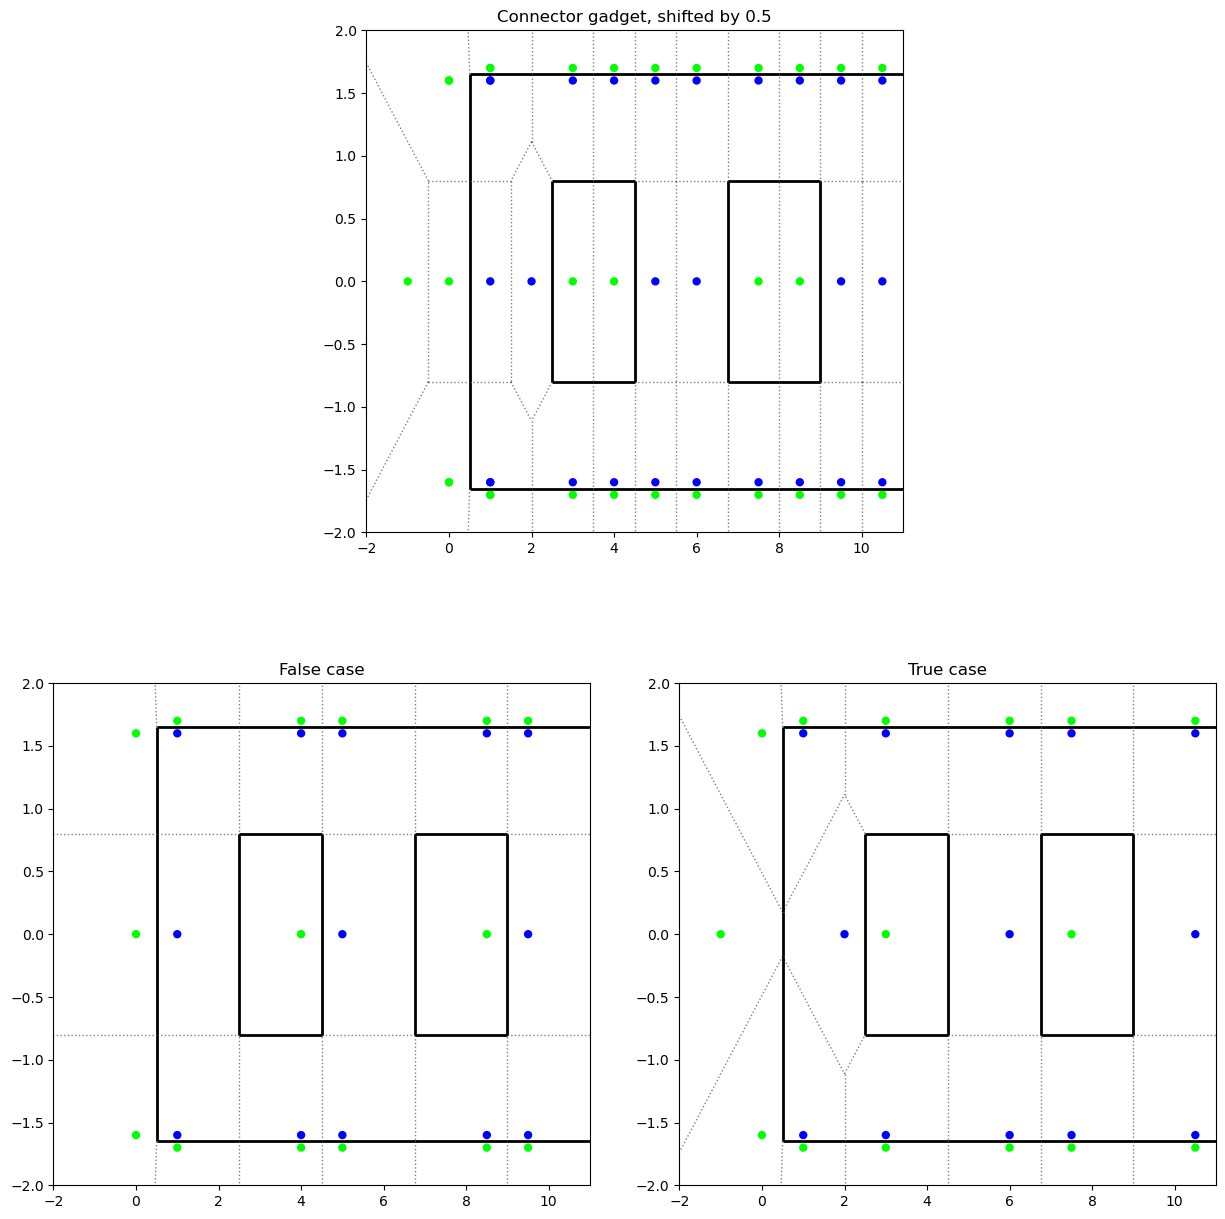

In [12]:
# dataset = np.array([[-7,0,1],[-6,0,0],[-4,1,0], [-4,2,1],[-5,1,0], [-5,2,1],[-3,0,0],[-2,0,1], [1,0,1], [2,0,0], [5,0,0], [6,0,1], [5,2.5,0]])
true_connector = np.array([[-10.5,0,0],[-7.5,0,1], [-6,0,0], [-3,0,1], [-2,0,0],[1,0,1]])
true_shielding = np.array([ [-10.5,1.6,0], [-10.5,1.7,1], [-10.5,-1.6,0], [-10.5,-1.7,1],[-7.5,1.6,0], [-7.5,1.7,1], [-7.5,-1.6,0], [-7.5,-1.7,1],[-6,1.6,0], [-6,1.7,1], [-6,-1.6,0], [-6,-1.7,1],[-3,1.6,0], [-3,1.7,1], [-3,-1.6,0], [-3,-1.7,1],[-1,1.6,0], [-1,1.7,1], [-1,-1.6,0], [-1,-1.7,1], [0,1.6,1],[0,-1.6,1]])
false_connector = np.array([[-9.5,0,0],[-8.5,0,1] , [-5,0,0], [-4,0,1], [-1,0,0],[0,0,1]])
false_shielding = np.array([[-9.5,1.6,0], [-9.5,1.7,1], [-9.5,-1.6,0], [-9.5,-1.7,1],[-8.5,1.6,0], [-8.5,1.7,1], [-8.5,-1.6,0], [-8.5,-1.7,1],[-5,1.6,0], [-5,1.7,1], [-5,-1.6,0], [-5,-1.7,1],[-4,1.6,0], [-4,1.7,1], [-4,-1.6,0], [-4,-1.7,1], [-1,1.6,0], [-1,1.7,1], [-1,-1.6,0], [-1,-1.7,1], [0,1.6,1], [0,-1.6,1]])

templist = true_connector.tolist()
for i in templist: 
    i[0] = -i[0]
true_connector = np.array(templist)

templist = true_shielding.tolist()
for i in templist: 
    i[0] = -i[0]
true_shielding = np.array(templist)

templist = false_connector.tolist()
for i in templist: 
    i[0] = -i[0]
false_connector = np.array(templist)

templist = false_shielding.tolist()
for i in templist: 
    i[0] = -i[0]
false_shielding = np.array(templist)


dataset = np.concatenate((true_connector,false_connector, true_shielding,false_shielding))
vor1 = Voronoi_with_color(np.concatenate((true_connector,false_connector, true_shielding,false_shielding)))
vor2 = Voronoi_with_color(np.concatenate((false_connector, false_shielding)))
vor3 = Voronoi_with_color(np.concatenate((true_connector, true_shielding)))

fig, ax = plt.subplots()
voronoi_plot_2d(vor1, ax = ax, show_vertices = False, show_irrelevant = True )
ax.set_ylim([-2,2])

fig = plt.figure(figsize = (15,15))
grid = plt.GridSpec(2, 4,figure=fig, wspace=0.4, hspace=0.3 )
ax1 = plt.subplot(grid[0,1:3])
ax2 = plt.subplot(grid[1,:2])
ax3  = plt.subplot(grid[1,2:4])
voronoi_plot_2d(vor1, ax = ax1, show_vertices = False, show_irrelevant = True, point_size= 100 )
voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True, point_size= 100 )
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True, point_size= 100 )
ax1.set_ylim([-2,2])
ax1.set_xlim([-2,11])
# ax1.get_xaxis().set_visible(False)
# ax1.get_yaxis().set_visible(False)
ax1.set_title('Connector gadget, shifted by 0.5')

ax2.set_ylim([-2,2])
ax2.set_xlim([-2,11])
# ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
ax2.set_title('False case')

ax3.set_ylim([-2,2])
ax3.set_xlim([-2,11])
# ax3.get_xaxis().set_visible(False)
# ax3.get_yaxis().set_visible(False)
ax3.set_title('True case')
plt.show()

# Variable Gadget

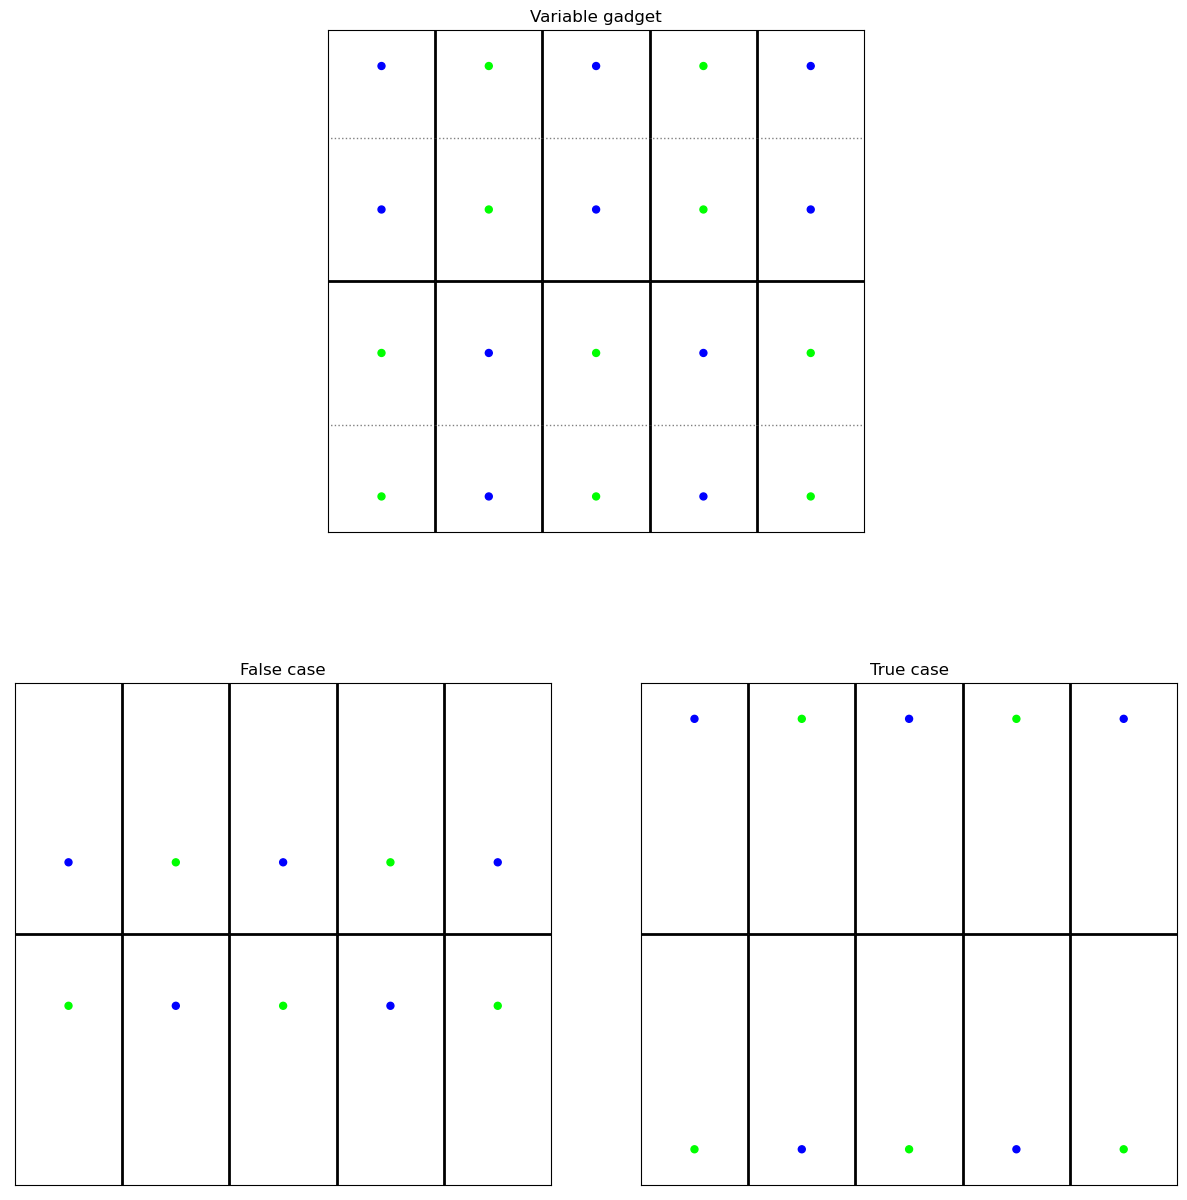

In [13]:
false_gadget = np.array([[-2,-1,1],[-1,-1,0], [0,-1,1], [1,-1,0],[2,-1,1], [-2,1,0],[-1,1,1], [0,1,0], [1,1,1],[2,1,0] ])
true_gadget = np.array([[-2,-3,1],[-1,-3,0], [0,-3,1], [1,-3,0],[2,-3,1], [-2,3,0],[-1,3,1], [0,3,0], [1,3,1],[2,3,0] ])
dataset = np.concatenate((true_gadget, false_gadget))
vor = Voronoi_with_color(dataset)
vor2 = Voronoi_with_color(false_gadget)
vor3 = Voronoi_with_color(true_gadget)

fig = plt.figure(figsize = (15,15))
grid = plt.GridSpec(2, 4,figure=fig, wspace=0.4, hspace=0.3 )
ax1 = plt.subplot(grid[0,1:3])
ax2 = plt.subplot(grid[1,:2])
ax3  = plt.subplot(grid[1,2:4])
voronoi_plot_2d(vor, ax = ax1, show_vertices = False, show_irrelevant = True, point_size= 100 )
voronoi_plot_2d(vor2, ax = ax2, show_vertices = False, show_irrelevant = True, point_size= 100 )
voronoi_plot_2d(vor3, ax = ax3, show_vertices = False, show_irrelevant = True, point_size= 100 )
ax1.set_xlim([-2.5, 2.5])
ax1.set_ylim([-3.5, 3.5])
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title('Variable gadget')

ax2.set_xlim([-2.5, 2.5])
ax2.set_ylim([-3.5, 3.5])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title('False case')

ax3.set_xlim([-2.5, 2.5])
ax3.set_ylim([-3.5, 3.5])
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title('True case')

# fig.savefig('../Figures/variable_gadget2')
plt.show()


# Shielding

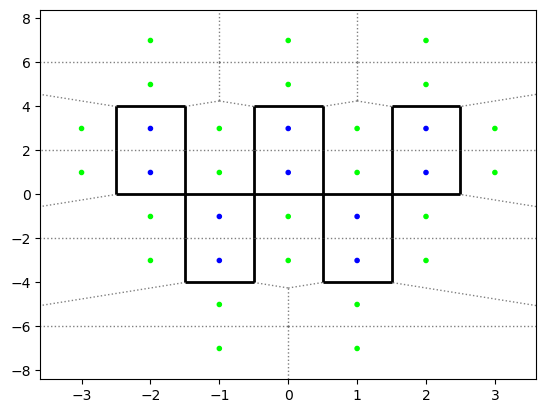

In [14]:
true_gadget = np.array([[-2,-1,1],[-1,-1,0], [0,-1,1], [1,-1,0],[2,-1,1], [-2,1,0],[-1,1,1], [0,1,0], [1,1,1],[2,1,0] ])
false_gadget = np.array([[-2,-3,1],[-1,-3,0], [0,-3,1], [1,-3,0],[2,-3,1], [-2,3,0],[-1,3,1], [0,3,0], [1,3,1],[2,3,0] ])
dataset = np.concatenate((true_gadget, false_gadget, [[1,5,0], [1,7,0],[1,9,1],[1,11,1], [1,13,0], [1,15,0],[1,17,1],[1,19,1], [-1,5,0]]))
dataset2 = np.concatenate((true_gadget, false_gadget, [[0,5,1],[0,7,1], [2,5,1],[2,7,1], [-2,5,1],[-2,7,1], [-1,-5,1],[-1,-7,1], [1,-5,1],[1,-7,1],[-3,1,1],[-3,3,1],[3,1,1],[3,3,1]]))
vor = Voronoi_with_color(dataset2)
vor2 = Voronoi_with_color(true_gadget)
vor3 = Voronoi_with_color(false_gadget)

fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax = ax, show_vertices = False, show_irrelevant = True )
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# fig.savefig('../Figures/variable_gadget_lid')
plt.show()